In [1]:
import cv2
import dlib
import numpy
import sys

PREDICTOR_PATH = r"C:\Users\82107\Downloads\shape_predictor_68_face_landmarks.dat\shape_predictor_68_face_landmarks.dat" ## 이 파일이 있는 경로로 수정

FEATHER_AMOUNT = 11
SCALE_FACTOR = 1
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return numpy.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [2]:
def cut_eyes(filename,landmarks):
    img = io.imread(filename+'.jpg')
    lx1=landmarks[0].item(0)
    lx2=landmarks[27].item(0)
    ly1=landmarks[37].item(1)+30
    
    return img[ly2:ly1,lx1:lx2,:]

In [3]:
def select_index_to_use(index_dark, index_medium, index_light):
    max = 0
    name_of_index = ""
    index_to_use = []
    
    if len(index_dark) > len(index_medium):
        max = len(index_dark)
        index_to_use = index_dark
        name_of_index = "Dark"
    else:
        max = len(index_medium)
        index_to_use = index_medium
        name_of_index = "Medium"
        
    if max < len(index_light):
        print("Light")
        index_to_use = index_light
    else:
        print(name_of_index)
        
    return index_to_use

In [4]:
def indexs_per_type(cut_eyes, lower_value, upper_value):

    #Light on eye Detection
    
    %matplotlib inline
    gray = cv2.cvtColor(cut_eyes, cv2.COLOR_BGR2GRAY)
    etval, thresholded = cv2.threshold(gray, upper_value, 255, cv2.THRESH_BINARY)
    
    
    index = []
    i = 0

    while i < cut_eyes.shape[0]:
        j = 0
        index_of_black = []
        while j < cut_eyes.shape[1]:
            if thresholded[i][j] == 0:
                index_of_black.append(i)
                index_of_black.append(j)
                index.append(index_of_black)
                index_of_black = []
            j += 1
        i += 1
    
    
    etval, thresholded = cv2.threshold(gray, lower_value, 255, cv2.THRESH_BINARY)

    
    i = 0

    while i < cut_eyes.shape[0]:
        j = 0
        index_deleted = []
        while j < cut_eyes.shape[1]:
            if thresholded[i][j] == 0:
                index_deleted.append(i)
                index_deleted.append(j)
                if index_deleted in index:
                    index.remove(index_deleted)
                index_deleted = []
            j += 1
        i += 1
        
    return index

In [5]:
import math

index_dark = []
index_medium = []
index_light = []

def eye_l_value(filename, landmarks):
  
    ## Cut_eyes

    cut_eyes = im[landmarks[37][0, 1]+1:landmarks[40][0, 1]+1, landmarks[37][0, 0]-2:landmarks[38][0, 0]+3, :]

    index_dark = indexs_per_type(cut_eyes, 35, 110)
    index_medium = indexs_per_type(cut_eyes, 50, 140)
    index_light = indexs_per_type(cut_eyes, 65, 150)
    
    index_to_use = select_index_to_use(index_dark, index_medium, index_light)
    
    eye_lab = cv2.cvtColor(cut_eyes, cv2.COLOR_RGB2LAB)
    eye_l_value = []

    i = 0
    while i < len(index_to_use):
        eye_l_value.append(eye_lab[index_to_use[i][0], index_to_use[i][1], 0])
        i += 1

    i = 0
    while i < int(len(eye_l_value)*15/85):
        eye_l_value.append(0)
        i += 1
        
    eye_l_value = np.array(eye_l_value)
    return math.sqrt(np.sum((eye_l_value - np.mean(eye_l_value))**2)/(eye_l_value.size)),eye_l_value.size,cut_eyes

In [6]:
import numpy as np

eyesize = np.array([])
for i in range(1742):
    filename = 'pantoneSkinTone/pantone'+str(i+1)
    im, landmarks = read_im_and_landmarks(filename+'.jpg')
    origin = im.copy()
    color_location = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int)
    rgb = im[color_location[0, 1], color_location[0, 0]][2],\
    im[color_location[0, 1], color_location[0, 0]][1], im[color_location[0, 1], color_location[0, 0]][0]

    im_annotated = (im, landmarks)
    im_annotated = annotate_landmarks(im, landmarks)
    std, leng, eyes = eye_l_value(filename,landmarks)
    eyesize = np.append(eyesize,[eyes.shape[1],eyes.shape[0]])

    print('-------'+str(i+1)+'가로길이: '+str(eyes.shape[1])+', 세로길이: '+str(eyes.shape[0])+'-------')

AttributeError: 'NoneType' object has no attribute 'shape'

In [9]:
eyex = np.array([])
eyey = np.array([])
for i in range(0,eyesize.size,2):
    eyex = np.append(eyex,eyesize[i])
    eyey = np.append(eyey,eyesize[i+1])

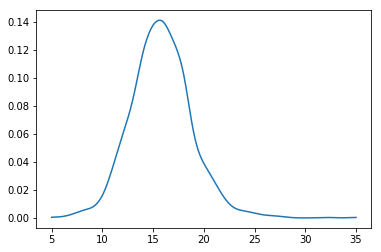

In [11]:
from scipy.stats import kde
import matplotlib.pyplot as plt     
density = kde.gaussian_kde(eyey) # x: list of price
xgrid = np.linspace(eyey.min(), eyey.max(), eyey.size)   
plt.plot(xgrid, density(xgrid))
plt.show()

In [12]:
##눈 세로 길이 10미만, 30이상 제거 eyes.shape[0]
##눈 가로 길이 18미만, 30이상 제거 eyes.shape[1]

In [13]:
pupil_len = np.array([])
pupil_std = np.array([])
for i in range(1742):
    filename = 'pantoneSkinTone/pantone'+str(i+1)
    im, landmarks = read_im_and_landmarks(filename+'.jpg')
    origin = im.copy()
    color_location = ((landmarks[54]+landmarks[11]+landmarks[45])/3).astype(int)
    rgb = im[color_location[0, 1], color_location[0, 0]][2],
    im[color_location[0, 1], color_location[0, 0]][1], im[color_location[0, 1], color_location[0, 0]][0]

    im_annotated = (im, landmarks)
    im_annotated = annotate_landmarks(im, landmarks)
    std, leng, eyes = eye_l_value(filename,landmarks)
    if(eyes.shape[0]>=10 & eyes.shape[0]<=30 & eyes.shape[1]>=18 & eyes.shape[1]<=30 & leng>10): # length 10이하 제거
        pupil_len = np.append(pupil_len, leng)
        pupil_std = np.append(pupil_std, std)
        print('-------'+str(i+1)+'번째 사진 길이: '+str(leng)+', 표준편차: '+str(std)+'-------')

Dark
-------1번째 사진 길이: 344, 표준편차: 32.526123040254056-------
Dark
-------2번째 사진 길이: 348, 표준편차: 31.63792268261762-------
Medium
-------3번째 사진 길이: 310, 표준편차: 41.28109536515893-------
Medium
-------4번째 사진 길이: 339, 표준편차: 43.481784950379954-------
Medium
Medium
-------6번째 사진 길이: 276, 표준편차: 42.62847240800882-------
Medium
Dark
Light
-------9번째 사진 길이: 343, 표준편차: 44.653104434679136-------
Medium
Dark
-------11번째 사진 길이: 215, 표준편차: 31.02887575051221-------
Medium
-------12번째 사진 길이: 347, 표준편차: 40.67844831844245-------
Light
-------13번째 사진 길이: 307, 표준편차: 52.7198995933537-------
Dark
-------14번째 사진 길이: 184, 표준편차: 29.80127499381677-------
Dark
Medium
-------16번째 사진 길이: 222, 표준편차: 42.65787289347034-------
Dark
Dark
Light
-------19번째 사진 길이: 191, 표준편차: 52.676867162842164-------
Dark
-------20번째 사진 길이: 337, 표준편차: 32.396197030692356-------
Dark
-------21번째 사진 길이: 188, 표준편차: 29.977317137788333-------
Dark
Medium
-------23번째 사진 길이: 438, 표준편차: 40.007784799997445-------
Medium
Dark
-------25번째 사진 길이: 313, 표준편

Dark
Medium
Medium
-------240번째 사진 길이: 214, 표준편차: 41.20645455640315-------
Medium
-------241번째 사진 길이: 222, 표준편차: 45.23027254595764-------
Medium
Medium
-------243번째 사진 길이: 212, 표준편차: 39.620859124331076-------
Light
Dark
-------245번째 사진 길이: 251, 표준편차: 34.32311820378591-------
Medium
Medium
Medium
Light
-------249번째 사진 길이: 339, 표준편차: 48.24453808246776-------
Medium
Light
-------251번째 사진 길이: 315, 표준편차: 48.968702115208984-------
Dark
-------252번째 사진 길이: 336, 표준편차: 32.46603064595663-------
Medium
-------253번째 사진 길이: 383, 표준편차: 45.497752365900816-------
Medium
Dark
-------255번째 사진 길이: 319, 표준편차: 30.5602784959654-------
Dark
-------256번째 사진 길이: 276, 표준편차: 34.66196676825546-------
Dark
Light
-------258번째 사진 길이: 317, 표준편차: 53.87488505009088-------
Light
-------259번째 사진 길이: 341, 표준편차: 47.61801757638673-------
Medium
-------260번째 사진 길이: 248, 표준편차: 42.97237011758104-------
Light
-------261번째 사진 길이: 281, 표준편차: 48.78151416430779-------
Medium
-------262번째 사진 길이: 343, 표준편차: 42.16805591450117-------
L

Medium
-------488번째 사진 길이: 309, 표준편차: 43.91994600740162-------
Light
Medium
Light
Light
Dark
Light
-------494번째 사진 길이: 183, 표준편차: 52.51070768378407-------
Dark
Medium
Dark
-------497번째 사진 길이: 220, 표준편차: 30.487775629093008-------
Medium
Light
-------499번째 사진 길이: 473, 표준편차: 52.0835919738746-------
Light
Dark
-------501번째 사진 길이: 283, 표준편차: 32.049448147693425-------
Dark
Light
Medium
-------504번째 사진 길이: 464, 표준편차: 39.99374184657653-------
Dark
Dark
Dark
Dark
Dark
Medium
Dark
Light
Medium
Light
Dark
-------515번째 사진 길이: 220, 표준편차: 35.38552022116269-------
Dark
-------516번째 사진 길이: 242, 표준편차: 32.21813167042379-------
Medium
-------517번째 사진 길이: 276, 표준편차: 42.4925058566832-------
Medium
-------518번째 사진 길이: 287, 표준편차: 41.776718402574986-------
Dark
-------519번째 사진 길이: 212, 표준편차: 32.20902378317523-------
Dark
-------520번째 사진 길이: 158, 표준편차: 34.58571160007427-------
Dark
-------521번째 사진 길이: 315, 표준편차: 32.933900680893494-------
Medium
Light
Dark
Dark
-------525번째 사진 길이: 180, 표준편차: 32.535877158440584-

Medium
Medium
Medium
Light
-------753번째 사진 길이: 311, 표준편차: 47.72476385112374-------
Medium
Dark
Dark
-------756번째 사진 길이: 246, 표준편차: 31.816898405184798-------
Dark
Medium
Light
-------759번째 사진 길이: 240, 표준편차: 48.14163114504488-------
Light
Medium
-------761번째 사진 길이: 348, 표준편차: 40.248256888800384-------
Dark
-------762번째 사진 길이: 185, 표준편차: 38.305200123019496-------
Dark
-------763번째 사진 길이: 191, 표준편차: 32.98916111340597-------
Dark
Dark
Dark
Medium
Dark
Medium
Dark
Dark
Medium
Dark
Dark
-------774번째 사진 길이: 275, 표준편차: 30.91434907146513-------
Dark
Light
Medium
-------777번째 사진 길이: 343, 표준편차: 41.3425491242972-------
Dark
Dark
Medium
Medium
-------781번째 사진 길이: 478, 표준편차: 45.07592124176156-------
Medium
-------782번째 사진 길이: 317, 표준편차: 39.89470762100844-------
Dark
Dark
Medium
-------785번째 사진 길이: 375, 표준편차: 43.20126335601259-------
Light
-------786번째 사진 길이: 347, 표준편차: 47.68744838982108-------
Light
-------787번째 사진 길이: 285, 표준편차: 50.14077124054941-------
Light
Dark
Medium
-------790번째 사진 길이: 247, 표준편

Dark
Medium
-------1027번째 사진 길이: 412, 표준편차: 43.99258305971802-------
Dark
-------1028번째 사진 길이: 337, 표준편차: 31.133299525922066-------
Dark
Dark
Medium
-------1031번째 사진 길이: 338, 표준편차: 40.3085705993809-------
Dark
-------1032번째 사진 길이: 287, 표준편차: 31.55523892277468-------
Dark
Medium
Dark
Medium
-------1036번째 사진 길이: 473, 표준편차: 41.62611854164511-------
Medium
-------1037번째 사진 길이: 434, 표준편차: 41.08010411149014-------
Medium
Dark
Dark
Light
-------1041번째 사진 길이: 275, 표준편차: 51.33888059898682-------
Dark
Dark
-------1043번째 사진 길이: 277, 표준편차: 30.120932949166104-------
Dark
Dark
Dark
Medium
-------1047번째 사진 길이: 311, 표준편차: 40.34870852184614-------
Dark
Medium
Dark
-------1050번째 사진 길이: 190, 표준편차: 31.524342702513-------
Dark
-------1051번째 사진 길이: 220, 표준편차: 31.57505128477805-------
Dark
Dark
-------1053번째 사진 길이: 220, 표준편차: 30.259027749261517-------
Light
Dark
Dark
Dark
-------1057번째 사진 길이: 215, 표준편차: 31.76996482881978-------
Dark
-------1058번째 사진 길이: 311, 표준편차: 30.705245290958214-------
Medium
Dark
Dark
-

Medium
-------1311번째 사진 길이: 274, 표준편차: 45.2908057573797-------
Dark
-------1312번째 사진 길이: 276, 표준편차: 34.46167363456746-------
Dark
-------1313번째 사진 길이: 247, 표준편차: 32.45409180984763-------
Medium
Dark
Dark
-------1316번째 사진 길이: 285, 표준편차: 31.01240848176663-------
Light
-------1317번째 사진 길이: 315, 표준편차: 45.883498555116134-------
Dark
-------1318번째 사진 길이: 316, 표준편차: 30.90972908887071-------
Dark
Dark
-------1320번째 사진 길이: 345, 표준편차: 31.914333452057882-------
Medium
-------1321번째 사진 길이: 310, 표준편차: 44.477157438610426-------
Light
-------1322번째 사진 길이: 217, 표준편차: 52.88806804479396-------
Medium
Medium
Dark
Dark
-------1326번째 사진 길이: 178, 표준편차: 28.321091753342593-------
Medium
-------1327번째 사진 길이: 310, 표준편차: 42.27419650219679-------
Dark
Dark
Dark
-------1330번째 사진 길이: 211, 표준편차: 31.668730163366973-------
Medium
-------1331번째 사진 길이: 285, 표준편차: 42.89186644146967-------
Medium
-------1332번째 사진 길이: 379, 표준편차: 41.783557186673555-------
Dark
-------1333번째 사진 길이: 314, 표준편차: 30.7677057992779-------
Dark
Med

Light
Dark
Dark
Medium
Medium
-------1560번째 사진 길이: 275, 표준편차: 38.12610376670756-------
Dark
Dark
Medium
-------1563번째 사진 길이: 178, 표준편차: 35.362774905385514-------
Dark
-------1564번째 사진 길이: 180, 표준편차: 31.52142128775288-------
Dark
Light
Medium
-------1567번째 사진 길이: 277, 표준편차: 42.606365132789925-------
Dark
-------1568번째 사진 길이: 253, 표준편차: 28.294029027587165-------
Dark
Medium
-------1570번째 사진 길이: 179, 표준편차: 39.34189355503862-------
Light
-------1571번째 사진 길이: 248, 표준편차: 44.65039924026768-------
Medium
-------1572번째 사진 길이: 217, 표준편차: 40.64135273753894-------
Medium
Light
Dark
Medium
Light
-------1577번째 사진 길이: 178, 표준편차: 52.61915557467878-------
Medium
Dark
-------1579번째 사진 길이: 222, 표준편차: 30.29231822529239-------
Dark
Medium
-------1581번째 사진 길이: 273, 표준편차: 38.546178976625214-------
Dark
Dark
-------1583번째 사진 길이: 212, 표준편차: 32.5693074835932-------
Dark
-------1584번째 사진 길이: 215, 표준편차: 29.93609346132619-------
Light
-------1585번째 사진 길이: 183, 표준편차: 50.1246426355051-------
Dark
-------1586번째 사진 길이

In [14]:
from sklearn.cluster import KMeans

In [15]:
std_final = np.array([])
for i in range(labels.size):
    if labels[i]==0:
        std_final = np.append(std_final,pupil_std[i])

NameError: name 'labels' is not defined

In [ ]:
kmeans = KMeans(n_clusters=2)
km_eln = kmeans.fit(np.reshape(std_final,(len(std_final),1)))
centroids = kmeans.cluster_centers_

labels = kmeans.labels_

print(centroids)

colors = ["g.","r."]

for i in range(len(std_final)):
    plt.plot(std_final[i], colors[labels[i]], markersize = 10)

plt.scatter(centroids[:, 0], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.show()

In [ ]:
#각 클러스터가 어떤 군집인지 보기 위한 것 
clu0=np.array([])
clu1=np.array([])
labels = clustering.labels_
for i,val in zip(labels,stds):
    if i == 0:
        clu0=np.append(clu0,val)
    else:
        clu1=np.append(clu1,val)
        
print("Dark L*value min: "+str(clu0.min()))
print("Dark L*value max: "+str(clu0.max()))
print("Light L*value min: "+str(clu1.min()))
print("Light L*value max: "+str(clu1.max()))
print("Boundary : "+str((clu0.max()+clu1.min())/2))
# 값이 작은 쪽이 분산이 작으므로 어두운 것, 큰 쪽이 밝은 것